In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchview
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=bc38edc816877d2504c3ad922489dc012a5a932197bb4b684c96e390e879fccc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import h5py
from torch import Tensor
from typing import Type
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torchview import draw_graph
from torchviz import make_dot
import warnings
warnings.filterwarnings("ignore")
from torchmetrics import Accuracy
import copy
import torch.optim as optim
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy
from torch.utils.data import TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

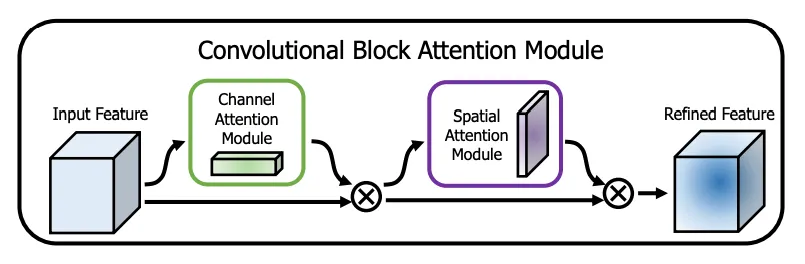

In [4]:
# -------------------------------------------------------
#                   Electron Images
# -------------------------------------------------------
filename = "/kaggle/input/gsoc-common-task-1-classification/Common Task - 1/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
hf = h5py.File(filename, 'r')
X_Electron = np.array(hf["X"][:])
Y_Electron = np.array(hf["y"][:])
Y_Electron[0]

# -------------------------------------------------------
#                   Photon Images
# -------------------------------------------------------
filename1 = '/kaggle/input/gsoc-common-task-1-classification/Common Task - 1/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
h = h5py.File(filename1, 'r')
X_Photon = np.array(h["X"][:])
Y_Photon = np.array(h["y"][:])
Y_Photon[0]

0.0

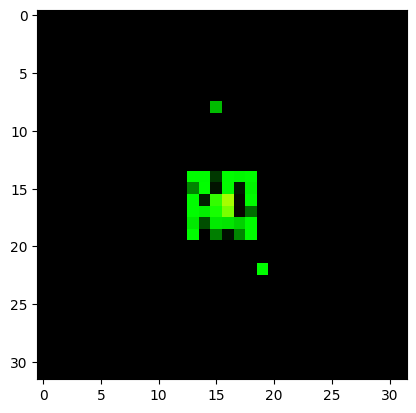

In [5]:
# -------------------------------------------------------
#                   Electron Plot
# -------------------------------------------------------


img = X_Electron[26500]
img = (img*255)
imgg = np.zeros((32,32,1))
img = np.dstack([img, imgg])
img = img.astype('uint8')
plt.imshow(img)

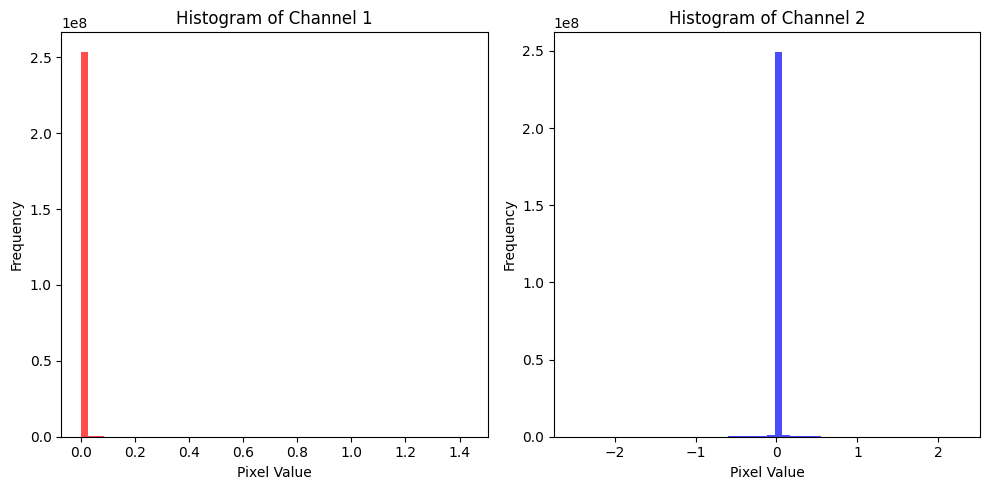

In [6]:
flattened_image = X_Electron.reshape((-1, 2))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(flattened_image[:, 0], bins=50, color='red', alpha=0.7)
plt.title('Histogram of Channel 1')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_image[:, 1], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Channel 2')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

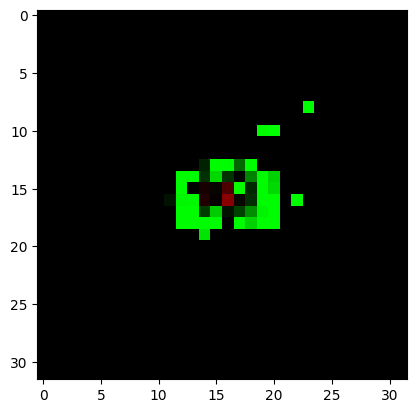

In [7]:
import matplotlib.pyplot as plt
img = X_Photon[0]
img = (img*255)
imgg = np.zeros((32,32,1))
img = np.dstack([img, imgg])
img = img.astype('uint8')
plt.imshow(img)

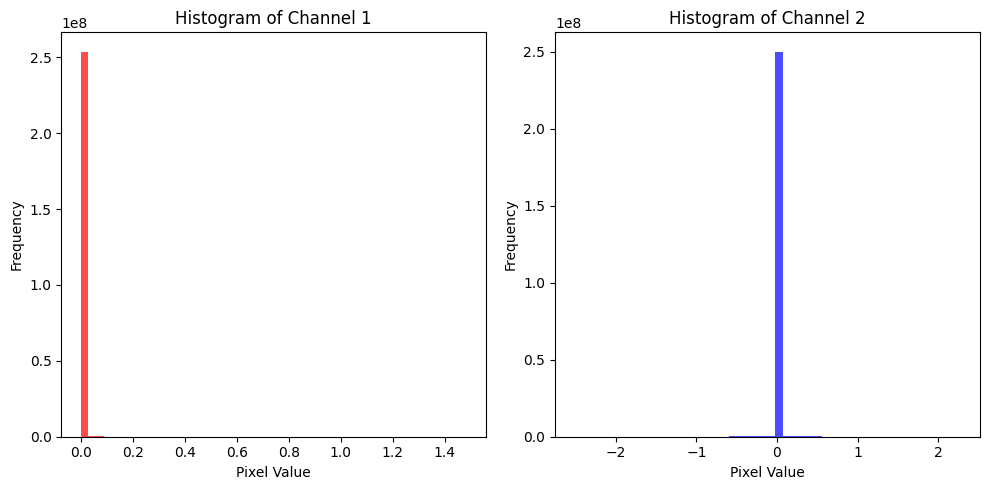

In [8]:
flattened_image = X_Photon.reshape((-1, 2))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(flattened_image[:, 0], bins=50, color='red', alpha=0.7)
plt.title('Histogram of Channel 1')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_image[:, 1], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Channel 2')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
X_train = np.concatenate((X_Electron, X_Photon), axis = 0)
X_train.shape

Y_train = np.concatenate((Y_Electron, Y_Photon))
Y_train.shape

(498000,)

In [10]:
# Assuming X_train and Y_train are your data and labels arrays
combined = list(zip(X_train, Y_train))
np.random.shuffle(combined)
X_train_shuffled, Y_train_shuffled = zip(*combined)

# Convert back to numpy arrays if necessary
X_train_shuffled = np.array(X_train_shuffled)
Y_train_shuffled = np.array(Y_train_shuffled)

In [11]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        
        x = self.conv(x)
        
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16):
        super(ChannelGate, self).__init__()
        
        # Number of input channels to image
        self.gate_channels = gate_channels
        
        #MLP layer
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )

    def forward(self, x):
        
        #Avg_pool
        avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_avg = self.mlp( avg_pool )

        #max_pool
        max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_max = self.mlp( max_pool )

        #Element wise sum
        channel_att_sum = channel_att_max + channel_att_avg

        #scaling output of channel attention to match dimensions with input
        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        
        return x * scale


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
        
    def forward(self, x):
        
        # Applying Average Pooling and Maxpooling layer and concatenating
        x_compress = self.compress(x)
        
        # Applying Convolution operation on concatenated inputs
        x_out = self.spatial(x_compress)
        
        # Applying Sigmoid to attention mask
        scale = F.sigmoid(x_out) # broadcasting
        
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=1, no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio)
        self.no_spatial=no_spatial
        
        if not no_spatial:
            self.SpatialGate = SpatialGate()
            
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

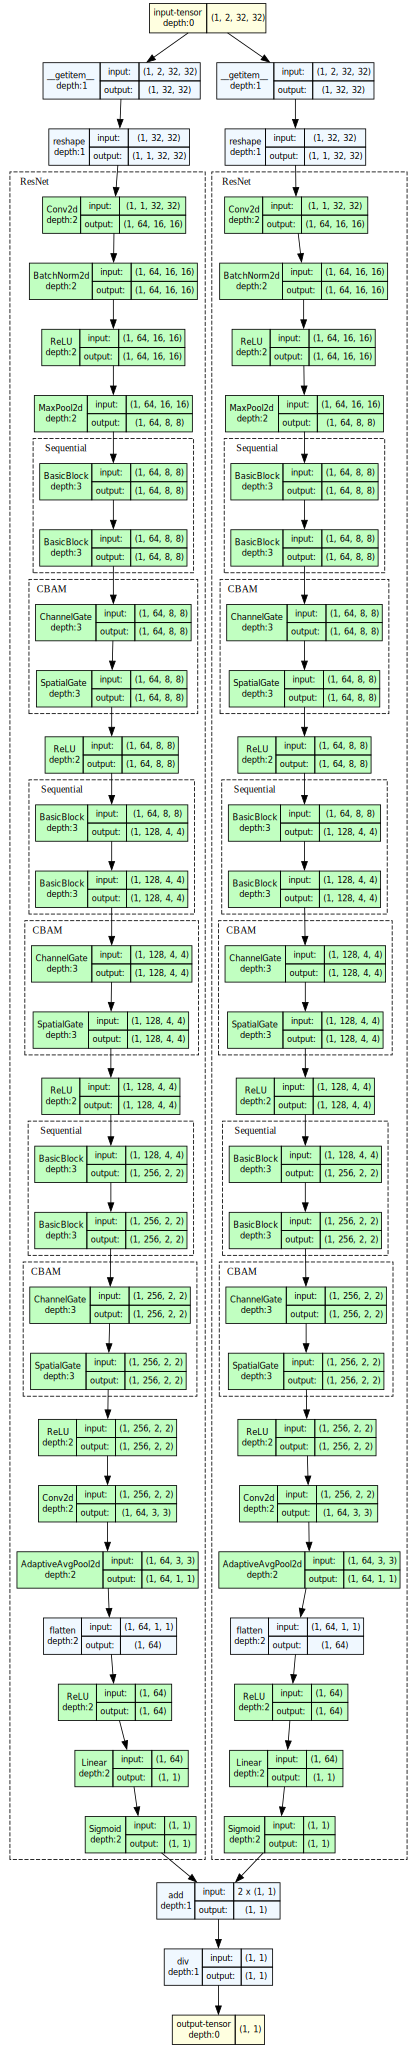

In [12]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int,out_channels: int,stride: int = 1,expansion: int = 1,downsample: nn.Module = None) -> None:
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=3, padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
        
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out
    
class ResNet(nn.Module):
    def __init__(
                    self, 
                    img_channels: int,
                    num_layers: int,
                    block: Type[BasicBlock],
                    cbam: Type[BasicBlock],
                    num_classes: int  = 2
                ) -> None:
        super(ResNet, self).__init__()
        
        if num_layers == 15:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
        self.expansion = 1
        self.in_channels = 64
        
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=64,
            kernel_size=3, 
            stride=2,
            padding=3,
            bias=False
        )
        
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.cbam_1 = self.channel_block_attention(cbam)
        
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.cbam_2 = self.channel_block_attention(cbam)
        
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.cbam_3 = self.channel_block_attention(cbam)
        
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64*self.expansion, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.2)
        
    def _make_layer(
                    self, 
                    block: Type[BasicBlock],
                    out_channels: int,
                    blocks: int,
                    stride: int = 1
                    ) -> nn.Sequential:
        
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                                        nn.Conv2d(
                                            self.in_channels, 
                                            out_channels*self.expansion,
                                            kernel_size=1,
                                            stride=stride,
                                            bias=False 
                                        ),
                                        nn.BatchNorm2d(out_channels * self.expansion),
                                      )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, self.expansion, downsample))
        
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels,out_channels,expansion=self.expansion))
            
        return nn.Sequential(*layers)
    
    def channel_block_attention(self, cbam):
        return cbam(self.in_channels)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.cbam_1(x) # Channel block attention module - 1
        x = self.relu(x)
        
    
        x = self.layer2(x)
        x = self.cbam_2(x) #Channel Block attention Module - 2
        x = self.relu(x)
        
        x = self.layer3(x)
        x = self.cbam_3(x) #Channel Block attention Module - 3
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.relu(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        
        return x
    
class Resnet_Ensemble(nn.Module):
    def __init__(self,img_channels:int,
                 num_layers: int,
                 block: Type[BasicBlock],
                 cbam: Type[CBAM],
                 resnet,
                 num_classes: int  = 2):
        
        super(Resnet_Ensemble, self).__init__()
        self.img_channels = img_channels
        self.num_layers = num_layers
        self.expansion = 1
        self.resnet_time = resnet(img_channels, num_layers, block, cbam)
        self.resnet_energy = resnet(img_channels, num_layers, block, cbam)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64*self.expansion, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.2)
        self.relu = nn.ReLU()
    
    def __make_layer(self, block):
        return 
    def forward(self, x):
        x_t = x[:,1,:,:]
        
        x_t = x_t.reshape((x_t.shape[0],1,x_t.shape[2], x_t.shape[2]))
        x_e = x[:,0,:,:]
        x_e = x_e.reshape((x_e.shape[0],1,x_e.shape[2], x_e.shape[2]))
        
        op_T = self.resnet_time(x_t)
        op_E = self.resnet_energy(x_e)
        
        op =  (op_T+op_E)/2
#         op = self.relu(op)
#         op = self.fc(op)
#         op = self.sigmoid(op)
        return op
        
        
model = Resnet_Ensemble(2, 15, BasicBlock, CBAM, ResNet)
model_graph = draw_graph(model, input_size=(1,2,32,32), expand_nested=True)
model_graph.visual_graph

In [13]:
class CustomDataset(Dataset):
    def __init__(self, x, y, transform = None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.x[idx]
        label = self.y[idx]
        label = torch.tensor(label).float().unsqueeze(0)
        if self.transform:
            img = self.transform(img)
        
        sample = {'image':img, 'labels' : label}
        
        return sample
            
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = CustomDataset(X_train_shuffled, Y_train_shuffled, transform = transform)

sample = dataset.__getitem__(0)
print(sample['image'].shape)
print(sample['labels'])

torch.Size([2, 32, 32])
tensor([0.])


In [14]:
def model_train(fold, model, epochs, train_dataloader, test_dataloader):
    
    # --------------------Loss function and optimizer--------------------
    criterion = nn.BCELoss()  # Binary Cross Entropy
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    # -------------------------------------------------------------------

    best_acc = -np.inf  # Init to negative infinity
    best_weights = None
    accuracy = Accuracy(task = 'binary').to(DEVICE)
 
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc='Epochs', unit='epoch'):
        train_pred = []
        val_pred = []
        
        # --------------------Training Loop--------------------
        model.train()
        for batch in train_dataloader:
            images, labels = batch['image'], batch['labels']
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_pred.append(loss.item())

            # Calculate training accuracy
            train_acc = accuracy(outputs, labels)
            train_accuracies.append(train_acc.item())

        train_loss = np.mean(train_pred)
        # -------------------------------------------------------
        # -------------------------------------------------------
        
        # --------------------Validation Loop--------------------
        model.eval()
        with torch.no_grad():
            for val_batch in test_dataloader:
                val_images, val_labels = val_batch['image'], val_batch['labels']
                val_images = val_images.to(DEVICE)
                val_labels = val_labels.to(DEVICE)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_pred.append(val_loss.item())

                # Calculate validation accuracy
                val_acc = accuracy(val_outputs, val_labels)
                val_accuracies.append(val_acc.item())

        val_loss = np.mean(val_pred)
        # -------------------------------------------------------
        # -------------------------------------------------------
        
        # Print and store losses and accuracies
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {np.mean(train_accuracies):.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {np.mean(val_accuracies):.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save best model
        if max(train_accuracies) > best_acc:
            best_acc = max(train_accuracies)
            best_weights = copy.deepcopy(model.state_dict())
    
    # Save the best model
    torch.save(best_weights, f'./best_model_{fold}.pth')

    # Plot training and validation losses
    return train_losses, val_losses, train_accuracies, val_accuracies


In [15]:
k_folds = 5
batch_size = 256

# -------------------------------------------------------
#                   Training KFold Starts
# -------------------------------------------------------
kf = KFold(n_splits=k_folds, shuffle=True)

trn_fold_loss = []
val_fold_loss = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    
    print(f'*** Fold {fold}***')
    print('Training Started.....')
    
    train_loader = DataLoader(dataset=dataset,batch_size=batch_size,sampler=torch.utils.data.SubsetRandomSampler(train_idx))
    test_loader = DataLoader(dataset=dataset,batch_size=batch_size,sampler=torch.utils.data.SubsetRandomSampler(test_idx))
    
    DEVICE = torch.device("cuda")
    model = Resnet_Ensemble(2, 15, BasicBlock, CBAM, resnet = ResNet)
    
    NUM_GPU = torch.cuda.device_count()
    if NUM_GPU > 1:
        model = nn.DataParallel(model)
    model = model.to(DEVICE)
    
    trn_loss, val_loss, trn_acc, val_acc = model_train(fold, model, epochs = 20, train_dataloader = train_loader, test_dataloader = test_loader)
    trn_fold_loss.append(trn_loss)
    val_fold_loss.append(val_loss)

*** Fold 0***
Training Started.....


Epochs:   5%|▌         | 1/20 [01:35<30:20, 95.83s/epoch]

Epoch 1/20, Train Loss: 0.5914, Train Accuracy: 0.6981, Valid Loss: 0.7262, Valid Accuracy: 0.5541


Epochs:  10%|█         | 2/20 [03:12<28:53, 96.31s/epoch]

Epoch 2/20, Train Loss: 0.5743, Train Accuracy: 0.7078, Valid Loss: 0.6222, Valid Accuracy: 0.6162


Epochs:  15%|█▌        | 3/20 [04:49<27:24, 96.73s/epoch]

Epoch 3/20, Train Loss: 0.5705, Train Accuracy: 0.7125, Valid Loss: 0.5702, Valid Accuracy: 0.6532


Epochs:  20%|██        | 4/20 [06:26<25:48, 96.80s/epoch]

Epoch 4/20, Train Loss: 0.5680, Train Accuracy: 0.7155, Valid Loss: 0.6001, Valid Accuracy: 0.6641


Epochs:  25%|██▌       | 5/20 [08:02<24:08, 96.55s/epoch]

Epoch 5/20, Train Loss: 0.5657, Train Accuracy: 0.7178, Valid Loss: 0.6153, Valid Accuracy: 0.6670


Epochs:  30%|███       | 6/20 [09:38<22:30, 96.44s/epoch]

Epoch 6/20, Train Loss: 0.5645, Train Accuracy: 0.7195, Valid Loss: 0.5743, Valid Accuracy: 0.6754


Epochs:  35%|███▌      | 7/20 [11:14<20:51, 96.26s/epoch]

Epoch 7/20, Train Loss: 0.5635, Train Accuracy: 0.7208, Valid Loss: 0.5728, Valid Accuracy: 0.6814


Epochs:  40%|████      | 8/20 [12:50<19:14, 96.23s/epoch]

Epoch 8/20, Train Loss: 0.5621, Train Accuracy: 0.7221, Valid Loss: 0.5663, Valid Accuracy: 0.6872


Epochs:  45%|████▌     | 9/20 [14:26<17:37, 96.11s/epoch]

Epoch 9/20, Train Loss: 0.5618, Train Accuracy: 0.7230, Valid Loss: 0.5667, Valid Accuracy: 0.6913


Epochs:  50%|█████     | 10/20 [16:03<16:02, 96.27s/epoch]

Epoch 10/20, Train Loss: 0.5607, Train Accuracy: 0.7239, Valid Loss: 0.5647, Valid Accuracy: 0.6953


Epochs:  55%|█████▌    | 11/20 [17:40<14:27, 96.38s/epoch]

Epoch 11/20, Train Loss: 0.5597, Train Accuracy: 0.7247, Valid Loss: 0.6024, Valid Accuracy: 0.6940


Epochs:  60%|██████    | 12/20 [19:16<12:51, 96.49s/epoch]

Epoch 12/20, Train Loss: 0.5590, Train Accuracy: 0.7254, Valid Loss: 0.5909, Valid Accuracy: 0.6955


Epochs:  65%|██████▌   | 13/20 [20:53<11:16, 96.58s/epoch]

Epoch 13/20, Train Loss: 0.5581, Train Accuracy: 0.7261, Valid Loss: 0.5661, Valid Accuracy: 0.6978


Epochs:  70%|███████   | 14/20 [22:30<09:39, 96.64s/epoch]

Epoch 14/20, Train Loss: 0.5576, Train Accuracy: 0.7268, Valid Loss: 0.5713, Valid Accuracy: 0.6998


Epochs:  75%|███████▌  | 15/20 [24:07<08:03, 96.66s/epoch]

Epoch 15/20, Train Loss: 0.5571, Train Accuracy: 0.7273, Valid Loss: 0.5665, Valid Accuracy: 0.7017


Epochs:  80%|████████  | 16/20 [25:43<06:26, 96.71s/epoch]

Epoch 16/20, Train Loss: 0.5566, Train Accuracy: 0.7279, Valid Loss: 0.5617, Valid Accuracy: 0.7035


Epochs:  85%|████████▌ | 17/20 [27:20<04:50, 96.75s/epoch]

Epoch 17/20, Train Loss: 0.5560, Train Accuracy: 0.7284, Valid Loss: 0.5572, Valid Accuracy: 0.7054


Epochs:  90%|█████████ | 18/20 [28:56<03:13, 96.58s/epoch]

Epoch 18/20, Train Loss: 0.5553, Train Accuracy: 0.7289, Valid Loss: 0.5579, Valid Accuracy: 0.7070


Epochs:  95%|█████████▌| 19/20 [30:33<01:36, 96.45s/epoch]

Epoch 19/20, Train Loss: 0.5553, Train Accuracy: 0.7293, Valid Loss: 0.6407, Valid Accuracy: 0.7018


Epochs: 100%|██████████| 20/20 [32:09<00:00, 96.49s/epoch]

Epoch 20/20, Train Loss: 0.5546, Train Accuracy: 0.7298, Valid Loss: 0.5588, Valid Accuracy: 0.7033
*** Fold 1***
Training Started.....



Epochs:   5%|▌         | 1/20 [01:36<30:29, 96.30s/epoch]

Epoch 1/20, Train Loss: 0.5918, Train Accuracy: 0.6978, Valid Loss: 0.6355, Valid Accuracy: 0.6563


Epochs:  10%|█         | 2/20 [03:12<28:55, 96.40s/epoch]

Epoch 2/20, Train Loss: 0.5737, Train Accuracy: 0.7076, Valid Loss: 0.6834, Valid Accuracy: 0.6431


Epochs:  15%|█▌        | 3/20 [04:49<27:17, 96.33s/epoch]

Epoch 3/20, Train Loss: 0.5692, Train Accuracy: 0.7124, Valid Loss: 0.6531, Valid Accuracy: 0.6393


Epochs:  20%|██        | 4/20 [06:26<25:45, 96.61s/epoch]

Epoch 4/20, Train Loss: 0.5669, Train Accuracy: 0.7154, Valid Loss: 0.5861, Valid Accuracy: 0.6564


Epochs:  25%|██▌       | 5/20 [08:04<24:16, 97.12s/epoch]

Epoch 5/20, Train Loss: 0.5645, Train Accuracy: 0.7177, Valid Loss: 0.5751, Valid Accuracy: 0.6679


Epochs:  30%|███       | 6/20 [09:41<22:39, 97.11s/epoch]

Epoch 6/20, Train Loss: 0.5634, Train Accuracy: 0.7193, Valid Loss: 0.5897, Valid Accuracy: 0.6733


Epochs:  35%|███▌      | 7/20 [11:17<20:59, 96.86s/epoch]

Epoch 7/20, Train Loss: 0.5617, Train Accuracy: 0.7208, Valid Loss: 0.5682, Valid Accuracy: 0.6803


Epochs:  40%|████      | 8/20 [12:53<19:20, 96.69s/epoch]

Epoch 8/20, Train Loss: 0.5603, Train Accuracy: 0.7220, Valid Loss: 0.5818, Valid Accuracy: 0.6839


Epochs:  45%|████▌     | 9/20 [14:31<17:46, 96.97s/epoch]

Epoch 9/20, Train Loss: 0.5585, Train Accuracy: 0.7231, Valid Loss: 0.5816, Valid Accuracy: 0.6862


Epochs:  50%|█████     | 10/20 [16:08<16:09, 97.00s/epoch]

Epoch 10/20, Train Loss: 0.5574, Train Accuracy: 0.7241, Valid Loss: 0.5680, Valid Accuracy: 0.6897


Epochs:  55%|█████▌    | 11/20 [17:45<14:32, 96.97s/epoch]

Epoch 11/20, Train Loss: 0.5563, Train Accuracy: 0.7250, Valid Loss: 0.6581, Valid Accuracy: 0.6821


Epochs:  60%|██████    | 12/20 [19:22<12:56, 97.06s/epoch]

Epoch 12/20, Train Loss: 0.5550, Train Accuracy: 0.7258, Valid Loss: 0.6687, Valid Accuracy: 0.6743


Epochs:  65%|██████▌   | 13/20 [20:58<11:17, 96.83s/epoch]

Epoch 13/20, Train Loss: 0.5534, Train Accuracy: 0.7265, Valid Loss: 0.5622, Valid Accuracy: 0.6785


Epochs:  70%|███████   | 14/20 [22:35<09:40, 96.72s/epoch]

Epoch 14/20, Train Loss: 0.5524, Train Accuracy: 0.7272, Valid Loss: 0.5752, Valid Accuracy: 0.6813


Epochs:  75%|███████▌  | 15/20 [24:11<08:03, 96.60s/epoch]

Epoch 15/20, Train Loss: 0.5510, Train Accuracy: 0.7279, Valid Loss: 0.5667, Valid Accuracy: 0.6844


Epochs:  80%|████████  | 16/20 [25:48<06:26, 96.61s/epoch]

Epoch 16/20, Train Loss: 0.5492, Train Accuracy: 0.7285, Valid Loss: 0.5779, Valid Accuracy: 0.6861


Epochs:  85%|████████▌ | 17/20 [27:24<04:49, 96.52s/epoch]

Epoch 17/20, Train Loss: 0.5479, Train Accuracy: 0.7291, Valid Loss: 0.6169, Valid Accuracy: 0.6849


Epochs:  90%|█████████ | 18/20 [29:00<03:12, 96.42s/epoch]

Epoch 18/20, Train Loss: 0.5464, Train Accuracy: 0.7297, Valid Loss: 0.5710, Valid Accuracy: 0.6872


Epochs:  95%|█████████▌| 19/20 [30:37<01:36, 96.45s/epoch]

Epoch 19/20, Train Loss: 0.5444, Train Accuracy: 0.7303, Valid Loss: 0.5783, Valid Accuracy: 0.6892


Epochs: 100%|██████████| 20/20 [32:13<00:00, 96.69s/epoch]

Epoch 20/20, Train Loss: 0.5431, Train Accuracy: 0.7309, Valid Loss: 0.6072, Valid Accuracy: 0.6886
*** Fold 2***
Training Started.....



Epochs:   5%|▌         | 1/20 [01:36<30:29, 96.27s/epoch]

Epoch 1/20, Train Loss: 0.5920, Train Accuracy: 0.6966, Valid Loss: 0.5880, Valid Accuracy: 0.7063


Epochs:  10%|█         | 2/20 [03:12<28:50, 96.12s/epoch]

Epoch 2/20, Train Loss: 0.5742, Train Accuracy: 0.7072, Valid Loss: 0.6282, Valid Accuracy: 0.6792


Epochs:  15%|█▌        | 3/20 [04:48<27:16, 96.25s/epoch]

Epoch 3/20, Train Loss: 0.5707, Train Accuracy: 0.7118, Valid Loss: 0.5770, Valid Accuracy: 0.6910


Epochs:  20%|██        | 4/20 [06:25<25:41, 96.34s/epoch]

Epoch 4/20, Train Loss: 0.5678, Train Accuracy: 0.7151, Valid Loss: 0.5944, Valid Accuracy: 0.6951


Epochs:  25%|██▌       | 5/20 [08:01<24:05, 96.35s/epoch]

Epoch 5/20, Train Loss: 0.5666, Train Accuracy: 0.7172, Valid Loss: 0.7637, Valid Accuracy: 0.6613


Epochs:  30%|███       | 6/20 [09:38<22:29, 96.40s/epoch]

Epoch 6/20, Train Loss: 0.5651, Train Accuracy: 0.7189, Valid Loss: 0.5755, Valid Accuracy: 0.6707


Epochs:  35%|███▌      | 7/20 [11:14<20:52, 96.35s/epoch]

Epoch 7/20, Train Loss: 0.5640, Train Accuracy: 0.7203, Valid Loss: 0.6275, Valid Accuracy: 0.6687


Epochs:  40%|████      | 8/20 [12:50<19:15, 96.27s/epoch]

Epoch 8/20, Train Loss: 0.5629, Train Accuracy: 0.7215, Valid Loss: 0.5806, Valid Accuracy: 0.6738


Epochs:  45%|████▌     | 9/20 [14:26<17:39, 96.33s/epoch]

Epoch 9/20, Train Loss: 0.5620, Train Accuracy: 0.7225, Valid Loss: 0.5657, Valid Accuracy: 0.6796


Epochs:  50%|█████     | 10/20 [16:03<16:03, 96.38s/epoch]

Epoch 10/20, Train Loss: 0.5616, Train Accuracy: 0.7234, Valid Loss: 0.5901, Valid Accuracy: 0.6821


Epochs:  55%|█████▌    | 11/20 [17:39<14:27, 96.38s/epoch]

Epoch 11/20, Train Loss: 0.5605, Train Accuracy: 0.7242, Valid Loss: 0.5612, Valid Accuracy: 0.6865


Epochs:  60%|██████    | 12/20 [19:15<12:50, 96.32s/epoch]

Epoch 12/20, Train Loss: 0.5597, Train Accuracy: 0.7249, Valid Loss: 0.5656, Valid Accuracy: 0.6900


Epochs:  65%|██████▌   | 13/20 [20:52<11:13, 96.28s/epoch]

Epoch 13/20, Train Loss: 0.5592, Train Accuracy: 0.7256, Valid Loss: 0.5699, Valid Accuracy: 0.6924


Epochs:  70%|███████   | 14/20 [22:28<09:37, 96.31s/epoch]

Epoch 14/20, Train Loss: 0.5583, Train Accuracy: 0.7263, Valid Loss: 0.6494, Valid Accuracy: 0.6870


Epochs:  75%|███████▌  | 15/20 [24:04<08:01, 96.30s/epoch]

Epoch 15/20, Train Loss: 0.5583, Train Accuracy: 0.7268, Valid Loss: 0.5648, Valid Accuracy: 0.6897


Epochs:  80%|████████  | 16/20 [25:41<06:25, 96.33s/epoch]

Epoch 16/20, Train Loss: 0.5577, Train Accuracy: 0.7273, Valid Loss: 0.5646, Valid Accuracy: 0.6921


Epochs:  85%|████████▌ | 17/20 [27:17<04:48, 96.27s/epoch]

Epoch 17/20, Train Loss: 0.5572, Train Accuracy: 0.7278, Valid Loss: 0.5640, Valid Accuracy: 0.6941


Epochs:  90%|█████████ | 18/20 [28:54<03:12, 96.42s/epoch]

Epoch 18/20, Train Loss: 0.5565, Train Accuracy: 0.7283, Valid Loss: 0.5617, Valid Accuracy: 0.6962


Epochs:  95%|█████████▌| 19/20 [30:30<01:36, 96.55s/epoch]

Epoch 19/20, Train Loss: 0.5562, Train Accuracy: 0.7287, Valid Loss: 0.5613, Valid Accuracy: 0.6980


Epochs: 100%|██████████| 20/20 [32:08<00:00, 96.44s/epoch]

Epoch 20/20, Train Loss: 0.5559, Train Accuracy: 0.7291, Valid Loss: 0.5617, Valid Accuracy: 0.6995
*** Fold 3***
Training Started.....



Epochs:   5%|▌         | 1/20 [01:38<31:20, 98.97s/epoch]

Epoch 1/20, Train Loss: 0.5933, Train Accuracy: 0.6953, Valid Loss: 0.7511, Valid Accuracy: 0.5235


Epochs:  10%|█         | 2/20 [03:15<29:14, 97.48s/epoch]

Epoch 2/20, Train Loss: 0.5754, Train Accuracy: 0.7058, Valid Loss: 0.6851, Valid Accuracy: 0.5581


Epochs:  15%|█▌        | 3/20 [04:52<27:36, 97.44s/epoch]

Epoch 3/20, Train Loss: 0.5703, Train Accuracy: 0.7108, Valid Loss: 0.5959, Valid Accuracy: 0.6022


Epochs:  20%|██        | 4/20 [06:29<25:52, 97.04s/epoch]

Epoch 4/20, Train Loss: 0.5679, Train Accuracy: 0.7139, Valid Loss: 0.6812, Valid Accuracy: 0.5971


Epochs:  25%|██▌       | 5/20 [08:05<24:13, 96.93s/epoch]

Epoch 5/20, Train Loss: 0.5658, Train Accuracy: 0.7161, Valid Loss: 0.5588, Valid Accuracy: 0.6241


Epochs:  30%|███       | 6/20 [09:42<22:35, 96.82s/epoch]

Epoch 6/20, Train Loss: 0.5637, Train Accuracy: 0.7180, Valid Loss: 0.5677, Valid Accuracy: 0.6407


Epochs:  35%|███▌      | 7/20 [11:19<20:58, 96.82s/epoch]

Epoch 7/20, Train Loss: 0.5622, Train Accuracy: 0.7195, Valid Loss: 0.5939, Valid Accuracy: 0.6480


Epochs:  40%|████      | 8/20 [12:55<19:20, 96.74s/epoch]

Epoch 8/20, Train Loss: 0.5609, Train Accuracy: 0.7207, Valid Loss: 0.5670, Valid Accuracy: 0.6576


Epochs:  45%|████▌     | 9/20 [14:32<17:42, 96.58s/epoch]

Epoch 9/20, Train Loss: 0.5592, Train Accuracy: 0.7218, Valid Loss: 0.5917, Valid Accuracy: 0.6618


Epochs:  50%|█████     | 10/20 [16:08<16:05, 96.54s/epoch]

Epoch 10/20, Train Loss: 0.5577, Train Accuracy: 0.7228, Valid Loss: 0.5587, Valid Accuracy: 0.6688


Epochs:  55%|█████▌    | 11/20 [17:44<14:27, 96.40s/epoch]

Epoch 11/20, Train Loss: 0.5565, Train Accuracy: 0.7238, Valid Loss: 0.5858, Valid Accuracy: 0.6723


Epochs:  60%|██████    | 12/20 [19:20<12:50, 96.33s/epoch]

Epoch 12/20, Train Loss: 0.5554, Train Accuracy: 0.7246, Valid Loss: 0.5609, Valid Accuracy: 0.6771


Epochs:  65%|██████▌   | 13/20 [20:57<11:14, 96.30s/epoch]

Epoch 13/20, Train Loss: 0.5537, Train Accuracy: 0.7254, Valid Loss: 0.5623, Valid Accuracy: 0.6812


Epochs:  70%|███████   | 14/20 [22:33<09:37, 96.20s/epoch]

Epoch 14/20, Train Loss: 0.5519, Train Accuracy: 0.7261, Valid Loss: 0.5775, Valid Accuracy: 0.6840


Epochs:  75%|███████▌  | 15/20 [24:09<08:01, 96.31s/epoch]

Epoch 15/20, Train Loss: 0.5506, Train Accuracy: 0.7268, Valid Loss: 0.5614, Valid Accuracy: 0.6872


Epochs:  80%|████████  | 16/20 [25:45<06:24, 96.23s/epoch]

Epoch 16/20, Train Loss: 0.5487, Train Accuracy: 0.7275, Valid Loss: 0.7589, Valid Accuracy: 0.6776


Epochs:  85%|████████▌ | 17/20 [27:22<04:48, 96.30s/epoch]

Epoch 17/20, Train Loss: 0.5466, Train Accuracy: 0.7282, Valid Loss: 0.5621, Valid Accuracy: 0.6808


Epochs:  90%|█████████ | 18/20 [28:59<03:13, 96.51s/epoch]

Epoch 18/20, Train Loss: 0.5447, Train Accuracy: 0.7288, Valid Loss: 0.5682, Valid Accuracy: 0.6834


Epochs:  95%|█████████▌| 19/20 [30:36<01:36, 96.62s/epoch]

Epoch 19/20, Train Loss: 0.5423, Train Accuracy: 0.7294, Valid Loss: 0.5657, Valid Accuracy: 0.6859


Epochs: 100%|██████████| 20/20 [32:12<00:00, 96.64s/epoch]

Epoch 20/20, Train Loss: 0.5395, Train Accuracy: 0.7301, Valid Loss: 0.5881, Valid Accuracy: 0.6870
*** Fold 4***
Training Started.....



Epochs:   5%|▌         | 1/20 [01:35<30:22, 95.93s/epoch]

Epoch 1/20, Train Loss: 0.5935, Train Accuracy: 0.6947, Valid Loss: 0.6349, Valid Accuracy: 0.6711


Epochs:  10%|█         | 2/20 [03:12<28:53, 96.28s/epoch]

Epoch 2/20, Train Loss: 0.5741, Train Accuracy: 0.7060, Valid Loss: 0.6204, Valid Accuracy: 0.6806


Epochs:  15%|█▌        | 3/20 [04:48<27:14, 96.13s/epoch]

Epoch 3/20, Train Loss: 0.5702, Train Accuracy: 0.7111, Valid Loss: 0.5704, Valid Accuracy: 0.6941


Epochs:  20%|██        | 4/20 [06:24<25:37, 96.12s/epoch]

Epoch 4/20, Train Loss: 0.5676, Train Accuracy: 0.7142, Valid Loss: 0.6216, Valid Accuracy: 0.6844


Epochs:  25%|██▌       | 5/20 [08:00<23:59, 95.95s/epoch]

Epoch 5/20, Train Loss: 0.5657, Train Accuracy: 0.7166, Valid Loss: 0.5692, Valid Accuracy: 0.6918


Epochs:  30%|███       | 6/20 [09:36<22:23, 95.95s/epoch]

Epoch 6/20, Train Loss: 0.5644, Train Accuracy: 0.7184, Valid Loss: 0.5955, Valid Accuracy: 0.6916


Epochs:  35%|███▌      | 7/20 [11:12<20:47, 95.97s/epoch]

Epoch 7/20, Train Loss: 0.5629, Train Accuracy: 0.7198, Valid Loss: 0.5644, Valid Accuracy: 0.6968


Epochs:  40%|████      | 8/20 [12:48<19:11, 95.99s/epoch]

Epoch 8/20, Train Loss: 0.5618, Train Accuracy: 0.7210, Valid Loss: 0.6053, Valid Accuracy: 0.6946


Epochs:  45%|████▌     | 9/20 [14:24<17:36, 96.04s/epoch]

Epoch 9/20, Train Loss: 0.5601, Train Accuracy: 0.7221, Valid Loss: 0.6366, Valid Accuracy: 0.6878


Epochs:  50%|█████     | 10/20 [16:00<15:59, 95.98s/epoch]

Epoch 10/20, Train Loss: 0.5590, Train Accuracy: 0.7230, Valid Loss: 0.5839, Valid Accuracy: 0.6897


Epochs:  55%|█████▌    | 11/20 [17:36<14:24, 96.09s/epoch]

Epoch 11/20, Train Loss: 0.5582, Train Accuracy: 0.7239, Valid Loss: 0.6080, Valid Accuracy: 0.6889


Epochs:  60%|██████    | 12/20 [19:12<12:48, 96.03s/epoch]

Epoch 12/20, Train Loss: 0.5569, Train Accuracy: 0.7247, Valid Loss: 0.7168, Valid Accuracy: 0.6757


Epochs:  65%|██████▌   | 13/20 [20:48<11:12, 96.09s/epoch]

Epoch 13/20, Train Loss: 0.5560, Train Accuracy: 0.7254, Valid Loss: 0.5671, Valid Accuracy: 0.6795


Epochs:  70%|███████   | 14/20 [22:24<09:36, 96.08s/epoch]

Epoch 14/20, Train Loss: 0.5547, Train Accuracy: 0.7260, Valid Loss: 0.5716, Valid Accuracy: 0.6825


Epochs:  75%|███████▌  | 15/20 [24:00<08:00, 96.00s/epoch]

Epoch 15/20, Train Loss: 0.5535, Train Accuracy: 0.7267, Valid Loss: 0.5728, Valid Accuracy: 0.6853


Epochs:  80%|████████  | 16/20 [25:36<06:24, 96.08s/epoch]

Epoch 16/20, Train Loss: 0.5523, Train Accuracy: 0.7273, Valid Loss: 0.5776, Valid Accuracy: 0.6874


Epochs:  85%|████████▌ | 17/20 [27:12<04:48, 96.09s/epoch]

Epoch 17/20, Train Loss: 0.5506, Train Accuracy: 0.7279, Valid Loss: 0.5886, Valid Accuracy: 0.6884


Epochs:  90%|█████████ | 18/20 [28:48<03:11, 95.93s/epoch]

Epoch 18/20, Train Loss: 0.5490, Train Accuracy: 0.7284, Valid Loss: 0.5652, Valid Accuracy: 0.6906


Epochs:  95%|█████████▌| 19/20 [30:24<01:36, 96.04s/epoch]

Epoch 19/20, Train Loss: 0.5475, Train Accuracy: 0.7290, Valid Loss: 0.5650, Valid Accuracy: 0.6927


Epochs: 100%|██████████| 20/20 [32:00<00:00, 96.04s/epoch]

Epoch 20/20, Train Loss: 0.5455, Train Accuracy: 0.7295, Valid Loss: 0.5728, Valid Accuracy: 0.6942


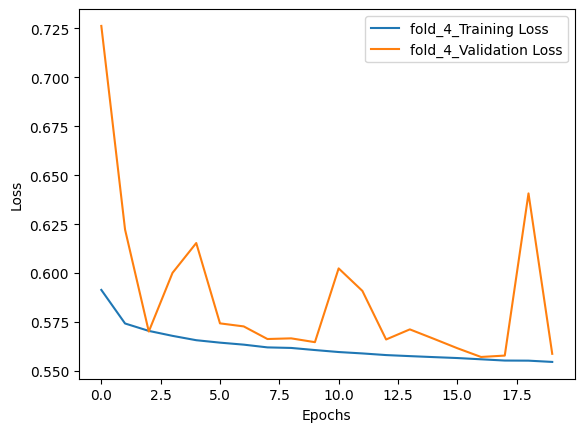

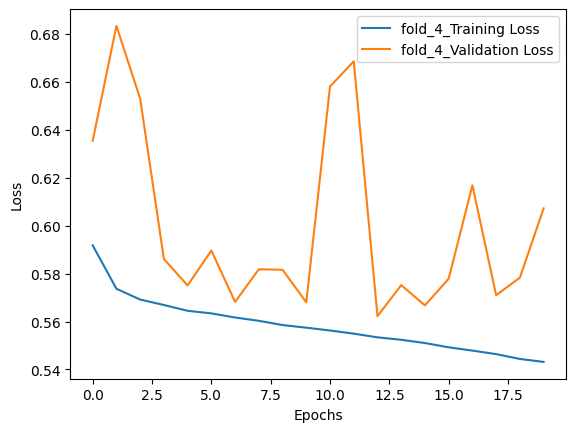

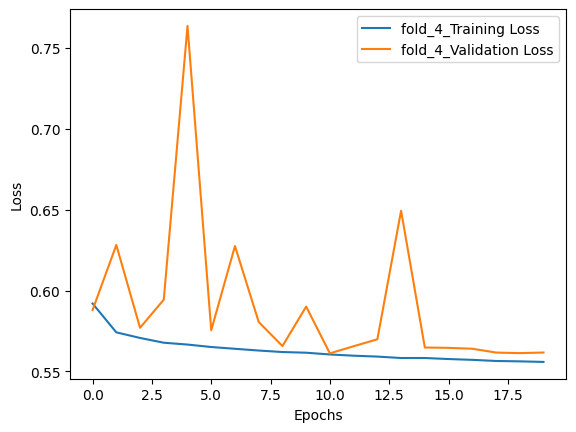

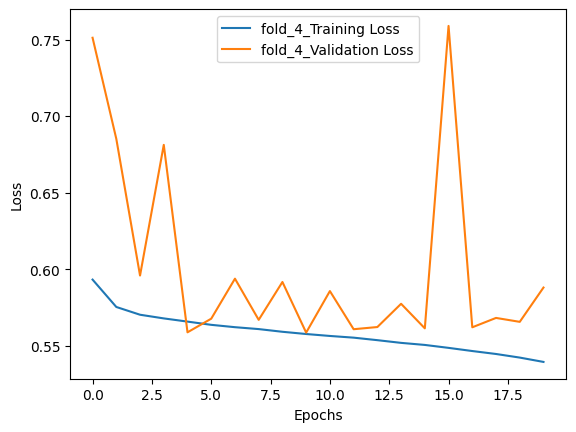

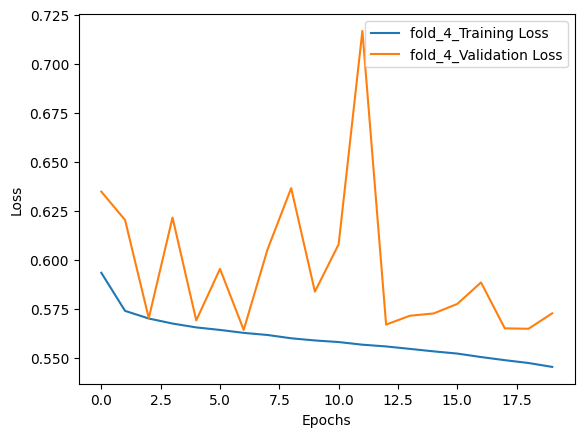

In [16]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.plot(trn_fold_loss[i], label=f'fold_{fold}_Training Loss')
    plt.plot(val_fold_loss[i], label=f'fold_{fold}_Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
